
# BioBERT for ICD-11 Vectorization

Based on the ICD2Vec methodology but applied to ICD-11 codes


# 1. Setup and Installation


In [1]:
# Install required packages
!pip install -q transformers torch pandas nltk matplotlib scikit-learn umap-learn seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.7 MB/s eta 0:00:00


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import torch
import time
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from transformers import AutoTokenizer, AutoModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import umap

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Set seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 2. Loading and Exploring the ICD-11 Data

In [3]:
# Load the ICD-11 data
icd11_df = pd.read_csv('icd11_data_raw.csv')

# Basic data exploration
print(f"Total number of ICD-11 codes: {len(icd11_df)}")
print(f"Number of columns: {len(icd11_df.columns)}")

# Display column names
print("\nColumns in the dataset:")
print(icd11_df.columns.tolist())

Total number of ICD-11 codes: 28087
Number of columns: 19

Columns in the dataset:
['id', 'code', 'title', 'browser_url', 'class_kind', 'definition', 'parent', 'inclusions', 'foundation_children', 'foundation_child_references', 'index_terms', 'related_entities', 'full_text', 'children', 'postcoordination_scales', 'index_term_references', 'exclusions', 'exclusion_references', 'fully_specified_name']


In [4]:
# Display the first few rows
icd11_df.head()

,id,code,title,browser_url,class_kind,definition,parent,inclusions,foundation_children,foundation_child_references,index_terms,related_entities,full_text,children,postcoordination_scales,index_term_references,exclusions,exclusion_references,fully_specified_name
0,1937339080,1C22,Infections due to Chlamydia psittaci,https://icd.who.int/browse/2023-01/mms/en#1937...,category,Any condition caused by an infection with the ...,1127435854,Psittacosis; Ornithosis; Parrot fever,Pneumonia in chlamydia psittaci infection,Pneumonia in chlamydia psittaci infection: htt...,Infections due to Chlamydia psittaci; Psittaco...,1935107489,Infections due to Chlamydia psittaci Any condi...,NaN,NaN,NaN,NaN,NaN,NaN
1,1671640403,1F51.0,Gambiense trypanosomiasis,https://icd.who.int/browse/2023-01/mms/en#1671...,category,A disease caused by an infection with the prot...,875488052,West African sleeping sickness; Infection due ...,NaN,NaN,NaN,1945127438,Gambiense trypanosomiasis A disease caused by ...,1842725899; other; unspecified,"{'axis_name': 'hasManifestation', 'required': ...",NaN,NaN,NaN,NaN
2,1528414070,1A07,Typhoid fever,https://icd.who.int/browse/2023-01/mms/en#1528...,category,A condition caused by an infection with the gr...,135352227,NaN,NaN,NaN,NaN,911707612,Typhoid fever A condition caused by an infecti...,364534567; other; unspecified,"{'axis_name': 'hasManifestation', 'required': ...",NaN,NaN,NaN,NaN
3,328097188,1A36.12,Cutaneous amoebiasis,https://icd.who.int/browse/2023-01/mms/en#3280...,category,NaN,1777228366,NaN,NaN,NaN,Cutaneous amoebiasis; Amoebiasis of skin; Amoe...,911707612,Cutaneous amoebiasis Cutaneous amoebiasis; Amo...,NaN,NaN,NaN,NaN,NaN,NaN
4,1483190070,1D03,Infectious abscess of the central nervous system,https://icd.who.int/browse/2023-01/mms/en#1483...,category,A focal suppurative process of the brain paren...,1585949804,NaN,NaN,NaN,NaN,911707612,Infectious abscess of the central nervous syst...,443087096; 613341872; 1147230459; 1128677700; ...,"{'axis_name': 'specificAnatomy', 'required': '...",NaN,NaN,NaN,NaN


In [5]:
# Check missing values
missing_values = icd11_df.isnull().sum()
print("\nMissing values per column:")
print(missing_values)


Missing values per column:
id                                 0
code                            1510
title                              1
browser_url                        0
class_kind                         0
definition                     20073
parent                             0
inclusions                     26528
foundation_children            26310
foundation_child_references    26310
index_terms                     3590
related_entities               25537
full_text                          0
children                       22664
postcoordination_scales        20958
index_term_references          24249
exclusions                     25595
exclusion_references           25619
fully_specified_name           27993
dtype: int64


In [6]:
# Check examples of text content in key columns
print("\nExample title:", icd11_df['title'].iloc[0])
if not pd.isna(icd11_df['definition'].iloc[0]):
    print("Example definition:", icd11_df['definition'].iloc[0][:150], "...")
if not pd.isna(icd11_df['inclusions'].iloc[0]):
    print("Example inclusions:", icd11_df['inclusions'].iloc[0])


Example title: Infections due to Chlamydia psittaci
Example definition: Any condition caused by an infection with the gram-negative bacteria Chlamydia psittaci. These conditions are characterised by variable clinical prese ...
Example inclusions: Psittacosis; Ornithosis; Parrot fever


In [7]:
# Analyze text length in different columns
icd11_df['title_length'] = icd11_df['title'].fillna('').apply(len)
icd11_df['definition_length'] = icd11_df['definition'].fillna('').apply(len)

print("\nText length statistics:")
print(f"Average title length: {icd11_df['title_length'].mean():.2f} characters")
print(f"Average definition length: {icd11_df['definition_length'].mean():.2f} characters")
print(f"Maximum definition length: {icd11_df['definition_length'].max()} characters")


Text length statistics:
Average title length: 30.90 characters
Average definition length: 81.18 characters
Maximum definition length: 6083 characters


# 3. Text Preprocessing

In [8]:
import nltk
nltk.download('punkt_tab')

# Text preprocessing function for BioBERT
def preprocess_text(text):
    """
    Preprocess text for BioBERT embedding.
    For BioBERT, we do minimal preprocessing as the model handles biomedical terminology well.
    """
    if pd.isna(text) or text == '':
        return ''

    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags and special characters
    text = re.sub('<.*?>', '', text)
    text = re.sub('[^a-zA-Z0-9\\s]', ' ', text)

    # Remove excessive whitespace
    text = re.sub('\\s+', ' ', text).strip()

    return text

# Create a combined text field from the most informative columns
icd11_df['combined_text'] = icd11_df.apply(
    lambda row: ' '.join(filter(None, [
        str(row['title'] or ''),
        str(row['definition'] or ''),
        str(row['inclusions'] or ''),
        str(row['index_terms'] or '')
    ])), axis=1
)

# Apply preprocessing to the combined text
icd11_df['processed_text'] = icd11_df['combined_text'].apply(preprocess_text)

# Display an example of processed text
print("\nExample of processed text:")
print(icd11_df['processed_text'].iloc[0])


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



Example of processed text:
infections due to chlamydia psittaci any condition caused by an infection with the gram negative bacteria chlamydia psittaci these conditions are characterised by variable clinical presentations such as fever cough headaches chills fatigue nausea vomiting diarrhoea or pneumonia transmission is commonly by inhalation of aersol contaminated with body fluids from infected birds or direct contact with infected birds confirmation is by identification of chlamydia psittaci psittacosis ornithosis parrot fever infections due to chlamydia psittaci psittacosis ornithosis parrot fever chlamydophila psittaci infection infections due to chlamydophila psittaci


# 4. BioBERT Model Implementation

In [9]:
# Load the BioBERT model and tokenizer
print("\nLoading BioBERT model...")
tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
model = AutoModel.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
print("BioBERT model loaded successfully")

# Function to get BioBERT embeddings for a text
def get_biobert_embedding(text, model, tokenizer, max_length=512):
    """
    Generate BioBERT embeddings for the given text.

    Parameters:
    -----------
    text : str
        Text to embed
    model : AutoModel
        Pre-trained BioBERT model
    tokenizer : AutoTokenizer
        BioBERT tokenizer
    max_length : int
        Maximum sequence length

    Returns:
    --------
    numpy.ndarray
        768-dimensional embedding vector
    """
    if not text or len(text.strip()) == 0:
        return np.zeros(768)  # Return zero vector for empty text

    # Truncate text if it's too long
    if len(text.split()) > max_length - 2:  # Account for [CLS] and [SEP] tokens
        text = ' '.join(text.split()[:max_length-2])

    # Tokenize and encode the text
    encoded_input = tokenizer(
        text,
        return_tensors='pt',
        padding='max_length',
        truncation=True,
        max_length=max_length
    )

    # Generate BioBERT embeddings
    with torch.no_grad():
        outputs = model(**encoded_input)
        # Use the [CLS] token embedding as the document representation
        embedding = outputs.last_hidden_state[:, 0, :].numpy()[0]

    return embedding


Loading BioBERT model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

BioBERT model loaded successfully


## BioBERT Model Implementation Explained

This section is loading BioBERT, a specialized language model specifically designed for biomedical text. Let me break it down in detail:

## What is BioBERT?

BioBERT is a domain-specific version of BERT (Bidirectional Encoder Representations from Transformers) that has been further pre-trained on biomedical literature. While the original BERT was trained on general text (books, Wikipedia), BioBERT was additionally trained on:

- **PubMed abstracts** (4.5 billion words)
- **PMC full-text articles** (13.5 billion words)

This additional training makes BioBERT much more effective at understanding medical terminology, relationships between medical concepts, and the nuanced language used in healthcare.

## The Code Components

```python
tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
model = AutoModel.from_pretrained('dmis-lab/biobert-base-cased-v1.1')
```

This code is doing two important things:

### 1. Loading the Tokenizer

The `AutoTokenizer` is responsible for:
- Breaking text into tokens (words or subwords)
- Converting tokens to numbers (IDs) that the model can process
- Adding special tokens like [CLS] (beginning of sequence) and [SEP] (separator)
- Handling casing (this is a cased model, so "Heart" and "heart" are treated differently)

For example, a text like "The patient has hypertension" might be tokenized into:
```
["[CLS]", "The", "patient", "has", "hyper", "##tension", "[SEP]"]
```

The "##" indicates a subword piece. Medical terms are often preserved better in BioBERT than in standard BERT.

### 2. Loading the Model

The `AutoModel` loads the actual neural network with:
- 12 transformer layers
- 768 hidden dimensions
- 12 attention heads
- ~110 million parameters pre-trained on biomedical text

This specific version (`biobert-base-cased-v1.1`) is the recommended version from the Korea University team that developed BioBERT.

## Why This Matters for ICD-11 Vectorization

Using BioBERT instead of standard BERT provides several critical advantages:

1. **Better Understanding of Medical Terminology**: BioBERT recognizes specialized medical terms and their relationships more accurately.

2. **Preservation of Clinical Meaning**: The model understands clinical contexts better - for example, that "discharge" has different meanings when referring to patient status versus wound conditions.

3. **Improved Rare Term Handling**: Medical terminology has many rare or specialized terms that general language models struggle with, but BioBERT has seen these during its pre-training.

4. **Higher Quality Embeddings**: The vectors produced by BioBERT better capture the meaningful relationships between medical concepts, which is crucial for ICD-11 code similarity and searching.

When we use this model to generate embeddings for ICD-11 codes, we're leveraging its specialized biomedical knowledge to create vector representations that more accurately reflect the relationships between different medical conditions and concepts.

# 5. Generating Embeddings for ICD-11 Codes

In [10]:
# Verify columns were created properly
print("Columns in icd11_df:", icd11_df.columns.tolist())
if 'processed_text' not in icd11_df.columns:
    print("The processed_text column is missing! Creating it now...")
    # Recreate the combined text field
    icd11_df['combined_text'] = icd11_df.apply(
        lambda row: ' '.join(filter(None, [
            str(row['title'] or ''),
            str(row['definition'] or ''),
            str(row['inclusions'] or ''),
            str(row['index_terms'] or '')
        ])), axis=1
    )
    # Apply preprocessing to the combined text
    icd11_df['processed_text'] = icd11_df['combined_text'].apply(preprocess_text)

# Process a smaller sample to avoid memory issues
sample_size = 1000  # Adjust based on your available RAM
sample_indices = np.random.choice(range(len(icd11_df)), sample_size, replace=False)
sample_df = icd11_df.iloc[sample_indices].copy().reset_index(drop=True)

# Generate BioBERT embeddings for the sample
print(f"\nGenerating BioBERT embeddings for {sample_size} ICD codes...")
start_time = time.time()

# Process in batches to manage memory usage
batch_size = 100
sample_df['biobert_vector'] = None  # Initialize the column

for i in range(0, len(sample_df), batch_size):
    end_idx = min(i + batch_size, len(sample_df))
    batch_start_time = time.time()
    print(f"Processing batch {i//batch_size + 1}/{(len(sample_df)-1)//batch_size + 1} ({i} to {end_idx-1})")

    # Apply the embedding function to each text in the batch
    embeddings = []
    for j in range(i, end_idx):
        text = sample_df.loc[j, 'processed_text']
        embedding = get_biobert_embedding(text, model, tokenizer)
        embeddings.append(embedding)

    # Store the embeddings
    for j, embedding in zip(range(i, end_idx), embeddings):
        sample_df.at[j, 'biobert_vector'] = embedding

    batch_end_time = time.time()
    print(f"  Batch processed in {batch_end_time - batch_start_time:.2f} seconds")

end_time = time.time()
print(f"BioBERT embeddings generated in {end_time - start_time:.2f} seconds")

Columns in icd11_df: ['id', 'code', 'title', 'browser_url', 'class_kind', 'definition', 'parent', 'inclusions', 'foundation_children', 'foundation_child_references', 'index_terms', 'related_entities', 'full_text', 'children', 'postcoordination_scales', 'index_term_references', 'exclusions', 'exclusion_references', 'fully_specified_name', 'title_length', 'definition_length', 'combined_text', 'processed_text']

Generating BioBERT embeddings for 1000 ICD codes...
Processing batch 1/10 (0 to 99)
  Batch processed in 189.33 seconds
Processing batch 2/10 (100 to 199)
  Batch processed in 185.71 seconds
Processing batch 3/10 (200 to 299)
  Batch processed in 187.22 seconds
Processing batch 4/10 (300 to 399)
  Batch processed in 186.19 seconds
Processing batch 5/10 (400 to 499)
  Batch processed in 187.64 seconds
Processing batch 6/10 (500 to 599)
  Batch processed in 186.84 seconds
Processing batch 7/10 (600 to 699)
  Batch processed in 187.02 seconds
Processing batch 8/10 (700 to 799)
  Batc

# 6. TF-IDF Vectorization for Comparison

In [11]:
# Generate TF-IDF vectors for comparison
print("\nGenerating TF-IDF vectors for comparison...")
start_time = time.time()

vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(sample_df['processed_text'])

# Reduce TF-IDF vectors to the same dimensionality as BioBERT for fair comparison
svd = TruncatedSVD(n_components=768)
tfidf_vectors = svd.fit_transform(tfidf_matrix)
sample_df['tfidf_vector'] = list(tfidf_vectors)

end_time = time.time()
print(f"TF-IDF vectors generated in {end_time - start_time:.2f} seconds")

# Compare dimensions
if len(sample_df) > 0:
    print(f"\nBioBERT vector dimensions: {len(sample_df['biobert_vector'].iloc[0])}")
    print(f"TF-IDF vector dimensions: {len(sample_df['tfidf_vector'].iloc[0])}")


Generating TF-IDF vectors for comparison...
TF-IDF vectors generated in 3.53 seconds

BioBERT vector dimensions: 768
TF-IDF vector dimensions: 768


# 7. Finding Similar ICD Codes

In [12]:
# Function to find similar codes
def find_similar_codes(query_code, vector_column, df, n=5):
    """
    Find the most similar codes to the query code based on cosine similarity.

    Parameters:
    -----------
    query_code : str
        The ICD-11 code to find similar codes for
    vector_column : str
        The column containing the vectors ('biobert_vector' or 'tfidf_vector')
    df : pandas.DataFrame
        DataFrame containing the codes and vectors
    n : int
        Number of similar codes to return

    Returns:
    --------
    list
        List of tuples containing (code, title, similarity)
    """
    if query_code not in df['code'].values:
        print(f"Code {query_code} not found in the dataset")
        return []

    query_vector = df.loc[df['code'] == query_code, vector_column].iloc[0]

    # Calculate cosine similarity
    similarities = []
    for idx, row in df.iterrows():
        if pd.isna(row['code']) or row['code'] == query_code:
            continue

        vector = row[vector_column]

        # Skip zero vectors
        if np.all(vector == 0) or np.all(query_vector == 0):
            continue

        similarity = np.dot(query_vector, vector) / (np.linalg.norm(query_vector) * np.linalg.norm(vector))
        similarities.append((row['code'], row['title'], similarity))

    # Sort by similarity (descending)
    similarities.sort(key=lambda x: x[2], reverse=True)

    return similarities[:n]

# Find a valid code from the sample for testing
valid_codes = sample_df['code'].dropna().tolist()
if valid_codes:
    test_code = valid_codes[0]
    print(f"\nTest code: {test_code} - {sample_df.loc[sample_df['code'] == test_code, 'title'].iloc[0]}")

    print("\nSimilar codes using BioBERT:")
    biobert_similar = find_similar_codes(test_code, 'biobert_vector', sample_df)
    for code, title, similarity in biobert_similar:
        print(f"  {code} - {title} (Similarity: {similarity:.4f})")

    print("\nSimilar codes using TF-IDF:")
    tfidf_similar = find_similar_codes(test_code, 'tfidf_vector', sample_df)
    for code, title, similarity in tfidf_similar:
        print(f"  {code} - {title} (Similarity: {similarity:.4f})")
else:
    print("No valid codes found in the sample")


Test code: XH8NE4 - Eccrine adenocarcinoma

Similar codes using BioBERT:
  XH3RK9 - Tubulolobular carcinoma (Similarity: 0.9840)
  XH0H07 - Hepatoblastoma, epithelioid (Similarity: 0.9759)
  XH0Q64 - Gynandroblastoma (Similarity: 0.9741)
  XH2ST9 - Infiltrating duct and cribriform carcinoma (Similarity: 0.9730)
  XH3DX0 - Metaplastic thymoma (Similarity: 0.9715)

Similar codes using TF-IDF:
  XH9G73 - Inflammatory carcinoma (Similarity: 0.3783)
  XH0A57 - Water-clear cell adenocarcinoma (Similarity: 0.2276)
  XH7TE3 - Follicular adenocarcinoma, moderately differentiated (Similarity: 0.1770)
  EH76.0 - Dermatoses resulting from cytotoxic or cancer chemotherapy (Similarity: 0.1037)
  2C61.0 - Invasive ductal carcinoma of breast (Similarity: 0.0921)


# 8. Visualizing the Embeddings


Visualizing embeddings using t-SNE and UMAP...


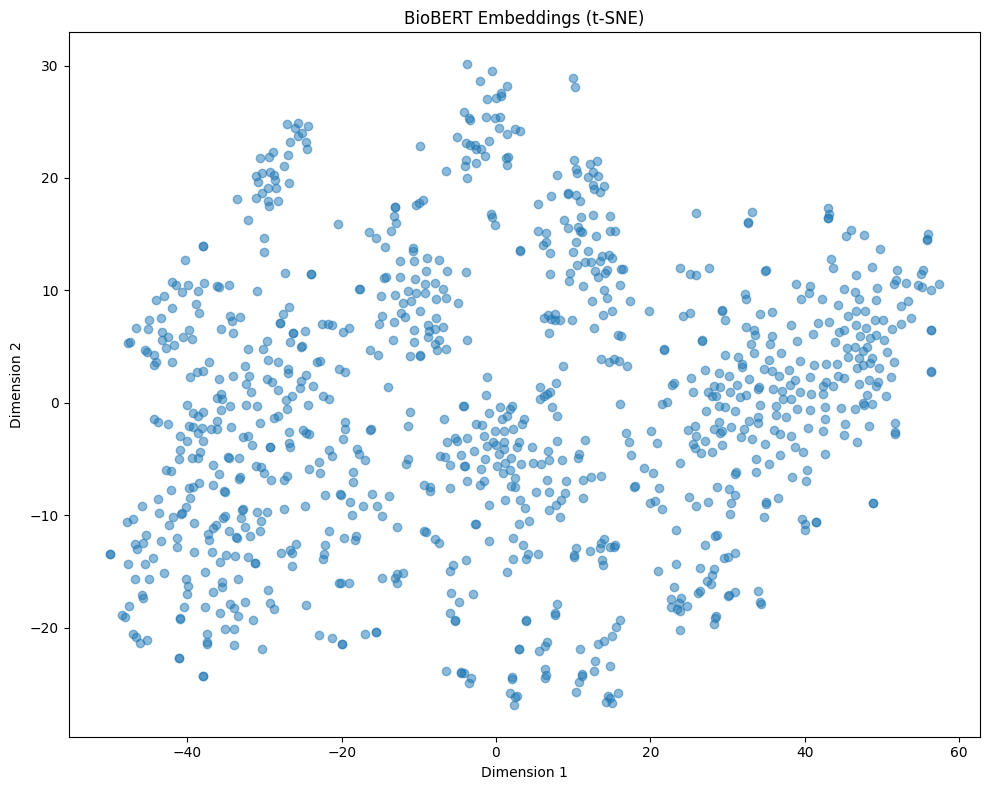

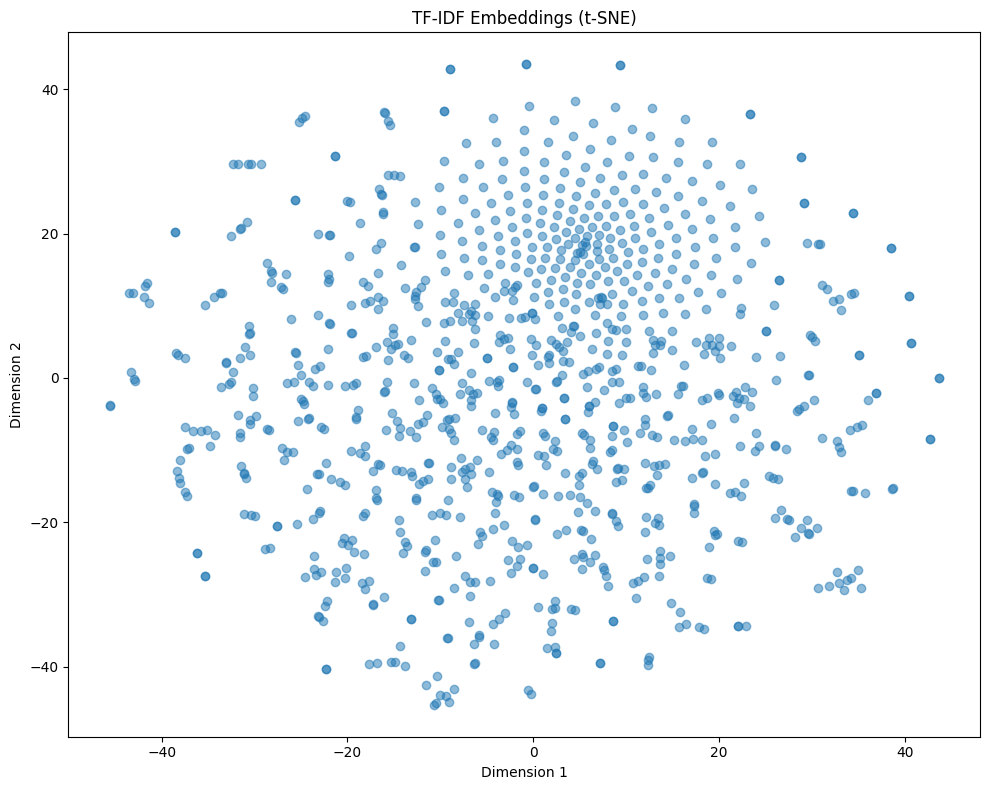

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


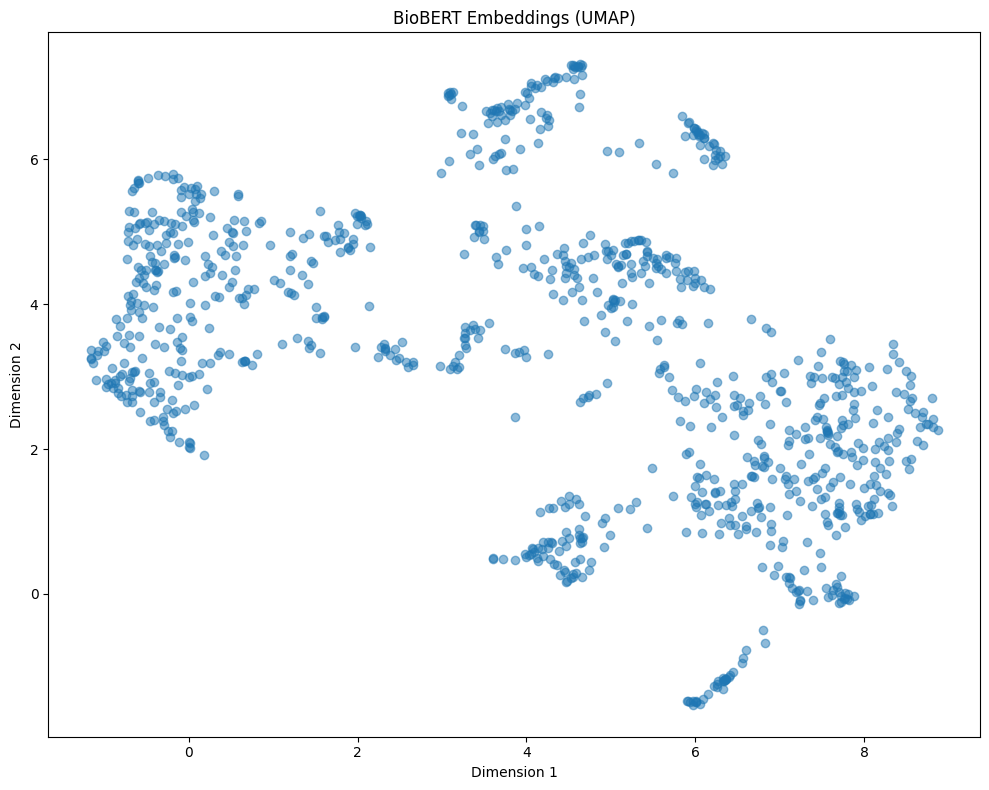

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


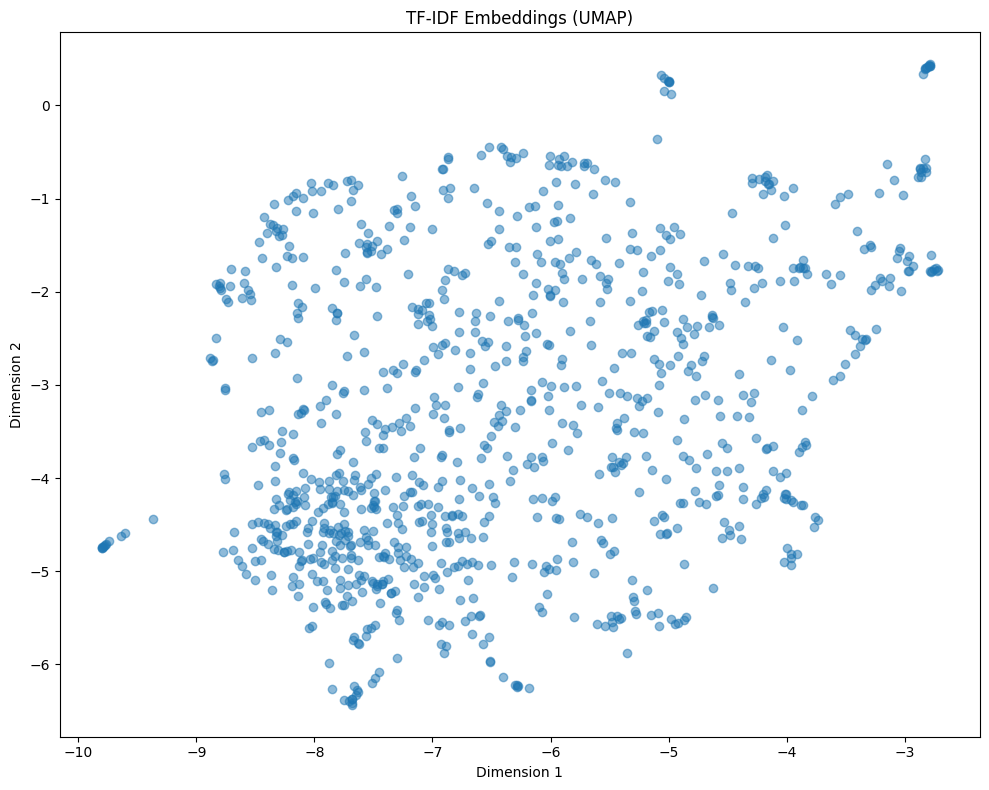

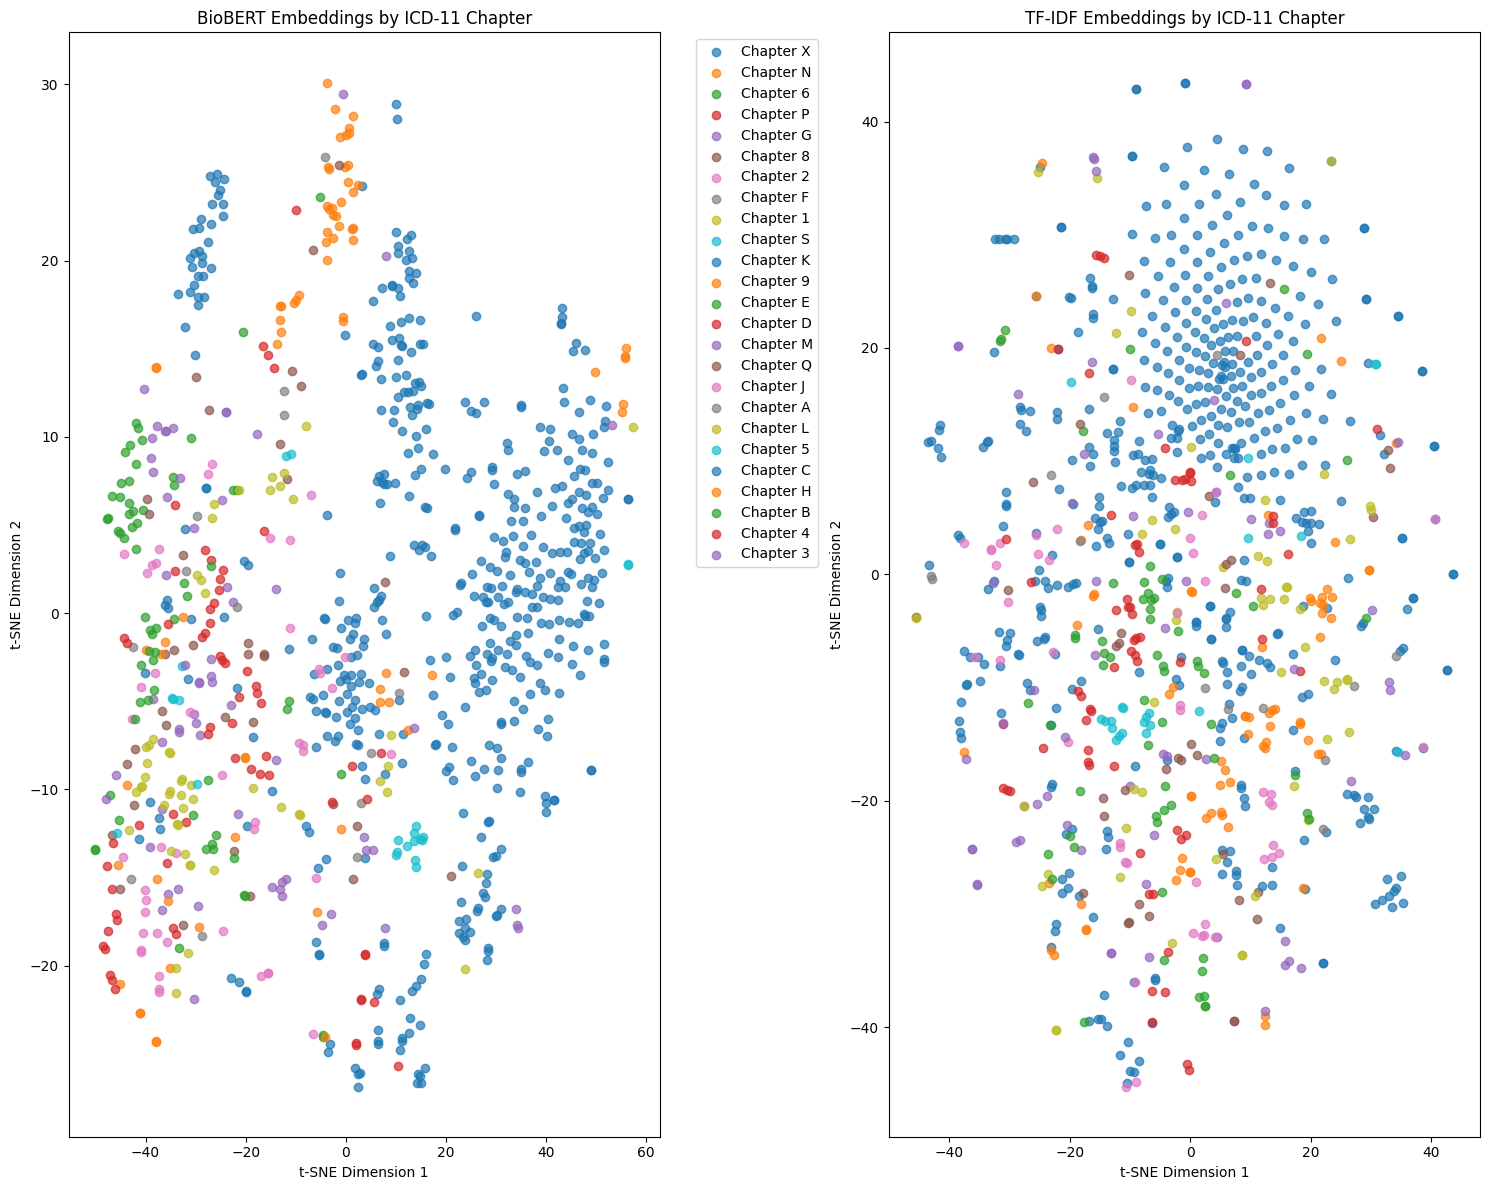

In [13]:
# Function to visualize embeddings
def visualize_embeddings(vectors, title, perplexity=30):
    """
    Create a t-SNE visualization of the embeddings.

    Parameters:
    -----------
    vectors : numpy.ndarray
        Array of embedding vectors
    title : str
        Title for the plot
    perplexity : int
        Perplexity parameter for t-SNE

    Returns:
    --------
    numpy.ndarray
        t-SNE reduced vectors
    """
    # Apply t-SNE dimensionality reduction
    perplexity = min(perplexity, len(vectors)-1)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    tsne_vectors = tsne.fit_transform(vectors)

    # Create scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1], alpha=0.5)
    plt.title(f"{title} Embeddings (t-SNE)")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.tight_layout()
    plt.show()

    return tsne_vectors

# Function to visualize embeddings using UMAP
def visualize_umap(vectors, title):
    """
    Create a UMAP visualization of the embeddings.
    UMAP often preserves more global structure than t-SNE.

    Parameters:
    -----------
    vectors : numpy.ndarray
        Array of embedding vectors
    title : str
        Title for the plot

    Returns:
    --------
    numpy.ndarray
        UMAP reduced vectors
    """
    # Apply UMAP dimensionality reduction
    reducer = umap.UMAP(random_state=42)
    umap_vectors = reducer.fit_transform(vectors)

    # Create scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(umap_vectors[:, 0], umap_vectors[:, 1], alpha=0.5)
    plt.title(f"{title} Embeddings (UMAP)")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.tight_layout()
    plt.show()

    return umap_vectors

# Visualize both embedding spaces if we have data
if len(sample_df) > 0:
    print("\nVisualizing embeddings using t-SNE and UMAP...")

    # Convert embeddings to numpy arrays for visualization
    biobert_vectors = np.array(sample_df['biobert_vector'].tolist())
    tfidf_vectors = np.array(sample_df['tfidf_vector'].tolist())

    # Visualize with t-SNE
    biobert_tsne = visualize_embeddings(biobert_vectors, "BioBERT")
    tfidf_tsne = visualize_embeddings(tfidf_vectors, "TF-IDF")

    # Visualize with UMAP (often better at preserving global structure)
    biobert_umap = visualize_umap(biobert_vectors, "BioBERT")
    tfidf_umap = visualize_umap(tfidf_vectors, "TF-IDF")

    # Visualize by ICD-11 chapter
    # Taking the first character of each code to determine its chapter
    sample_df['chapter'] = sample_df['code'].fillna('').apply(
        lambda x: x[0] if isinstance(x, str) and len(x) > 0 else 'Unknown'
    )

    # Plot the embeddings colored by chapter using t-SNE
    plt.figure(figsize=(15, 12))

    # BioBERT embeddings by chapter
    plt.subplot(1, 2, 1)
    for chapter in sample_df['chapter'].unique():
        if chapter == 'Unknown':
            continue
        indices = sample_df[sample_df['chapter'] == chapter].index
        if len(indices) > 0:
            plt.scatter(
                biobert_tsne[indices, 0],
                biobert_tsne[indices, 1],
                alpha=0.7,
                label=f"Chapter {chapter}"
            )
    plt.title("BioBERT Embeddings by ICD-11 Chapter")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # TF-IDF embeddings by chapter
    plt.subplot(1, 2, 2)
    for chapter in sample_df['chapter'].unique():
        if chapter == 'Unknown':
            continue
        indices = sample_df[sample_df['chapter'] == chapter].index
        if len(indices) > 0:
            plt.scatter(
                tfidf_tsne[indices, 0],
                tfidf_tsne[indices, 1],
                alpha=0.7,
                label=f"Chapter {chapter}"
            )
    plt.title("TF-IDF Embeddings by ICD-11 Chapter")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")

    plt.tight_layout()
    plt.show()

## Why Visualize Embeddings?

First, it's important to understand why visualization is necessary. BioBERT creates 768-dimensional vectors for each ICD code. These high-dimensional spaces are impossible to visualize directly, yet understanding how codes relate to each other spatially is crucial for evaluating the model. Dimensionality reduction allows us to project these relationships into a 2D space we can actually see.

## The Two Visualization Approaches

### 1. t-SNE Visualization Function

```python
def visualize_embeddings(vectors, title, perplexity=30):
```

This function implements t-SNE (t-distributed Stochastic Neighbor Embedding), which works by:

- Converting high-dimensional similarities between points into joint probabilities
- Creating a similar probability distribution in low-dimensional space
- Minimizing the difference between these distributions (using KL divergence)

The key parameter here is `perplexity`, which essentially controls how many neighbors each point considers. It's like adjusting the "focus" of your visualization - too low and you only see very local structure; too high and everything blurs together.

The line `perplexity = min(perplexity, len(vectors)-1)` is a safety check to prevent errors when the dataset is smaller than the perplexity value.

### 2. UMAP Visualization Function

```python
def visualize_umap(vectors, title):
```

UMAP (Uniform Manifold Approximation and Projection) is a newer technique with advantages over t-SNE:

- Better preservation of global structure (the "big picture" relationships)
- Generally faster computation
- Better preservation of meaningful distances between clusters
- More stable results across different runs

UMAP constructs a high-dimensional graph representation of your data and then optimizes a low-dimensional graph to be as structurally similar as possible.


## What to Look For in the Visualizations

1. **Clustering by chapter**: Good embeddings should show codes from the same chapter clustering together. In BioBERT, we expect stronger clustering than in TF-IDF.

2. **Meaningful proximity**: Related concepts should appear close together, even if they cross chapter boundaries. For instance, a viral hepatitis (infectious disease) might appear near other liver disorders.

3. **Global structure**: UMAP should show a more coherent global structure than t-SNE, potentially revealing higher-level relationships between disease categories.

4. **Clean separation**: Unrelated disease concepts should be well-separated in the embedding space.

5. **Comparison between models**: The BioBERT visualization should show more clinically meaningful arrangements than TF-IDF, which mainly captures word co-occurrence patterns.


# 9. Contextual Understanding with BioBERT

In [14]:
# Function to demonstrate BioBERT's contextual understanding
def demonstrate_biobert_context():
    """
    Demonstrate how BioBERT understands the same biomedical term differently in different contexts.
    """
    # Medical terms with different meanings in different contexts
    contexts = [
        ("discharge", "The patient is ready for discharge from the hospital."),
        ("discharge", "There was abnormal discharge from the wound."),
        ("cold", "The patient has a cold and is experiencing congestion."),
        ("cold", "The patient's extremities were cold to the touch."),
        ("operation", "The patient underwent a surgical operation on the heart."),
        ("operation", "The operation of this medical device is complex.")
    ]

    embeddings = []
    for term, context in contexts:
        # Create a tokenized input
        encoded_input = tokenizer(context, return_tensors='pt')

        # Generate full BioBERT embeddings
        with torch.no_grad():
            outputs = model(**encoded_input)
            # Get all token embeddings
            token_embeddings = outputs.last_hidden_state[0]

        # Convert tokenizer indices to words
        tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0])

        # Find the term in the tokenized text
        term_indices = []
        for i, token in enumerate(tokens):
            if term.lower() in token.lower():
                term_indices.append(i)

        if term_indices:
            # Extract the embedding for the target term (average if split into subwords)
            term_embedding = token_embeddings[term_indices].mean(dim=0).numpy()
            embeddings.append((term, context, term_embedding))

    # Calculate similarities between the same term in different contexts
    print("\nDemonstrating BioBERT's contextual understanding of medical terms:")
    for i in range(0, len(embeddings), 2):
        if i+1 < len(embeddings) and embeddings[i][0] == embeddings[i+1][0]:
            term = embeddings[i][0]
            context1 = embeddings[i][1]
            context2 = embeddings[i+1][1]
            embedding1 = embeddings[i][2]
            embedding2 = embeddings[i+1][2]

            # Calculate cosine similarity
            similarity = np.dot(embedding1, embedding2) / (
                np.linalg.norm(embedding1) * np.linalg.norm(embedding2)
            )

            print(f"\nTerm: '{term}'")
            print(f"Context 1: '{context1}'")
            print(f"Context 2: '{context2}'")
            print(f"Similarity between contexts: {similarity:.4f}")
            print("A lower similarity indicates BioBERT distinguishes different meanings based on context.")

# Demonstrate BioBERT's contextual understanding
demonstrate_biobert_context()


Demonstrating BioBERT's contextual understanding of medical terms:

Term: 'discharge'
Context 1: 'The patient is ready for discharge from the hospital.'
Context 2: 'There was abnormal discharge from the wound.'
Similarity between contexts: 0.8027
A lower similarity indicates BioBERT distinguishes different meanings based on context.

Term: 'cold'
Context 1: 'The patient has a cold and is experiencing congestion.'
Context 2: 'The patient's extremities were cold to the touch.'
Similarity between contexts: 0.8006
A lower similarity indicates BioBERT distinguishes different meanings based on context.

Term: 'operation'
Context 1: 'The patient underwent a surgical operation on the heart.'
Context 2: 'The operation of this medical device is complex.'
Similarity between contexts: 0.7802
A lower similarity indicates BioBERT distinguishes different meanings based on context.


# 10. Natural Language Search for ICD Codes

In [15]:
# Function to search for ICD codes using natural language
def search_icd_codes(query, df, n=5):
    """
    Search for ICD-11 codes using natural language.

    Parameters:
    -----------
    query : str
        Natural language query
    df : pandas.DataFrame
        DataFrame containing codes and embeddings
    n : int
        Number of results to return

    Returns:
    --------
    list
        List of tuples containing (code, title, similarity score)
    """
    # Preprocess query
    processed_query = preprocess_text(query)

    # Get BioBERT embedding for query
    query_vector = get_biobert_embedding(processed_query, model, tokenizer)

    # Calculate similarity with all codes
    similarities = []
    for idx, row in df.iterrows():
        if pd.isna(row['code']):
            continue

        vector = row['biobert_vector']

        # Skip zero vectors
        if np.all(vector == 0):
            continue

        similarity = np.dot(query_vector, vector) / (np.linalg.norm(query_vector) * np.linalg.norm(vector))
        similarities.append((row['code'], row['title'], similarity))

    # Sort by similarity
    similarities.sort(key=lambda x: x[2], reverse=True)

    return similarities[:n]

# Demonstrate natural language search
print("\nDemonstrating natural language search for ICD codes using BioBERT:")
search_queries = [
    "chest pain with shortness of breath and sweating",
    "chronic lower back pain that radiates down the leg",
    "elevated blood glucose levels and increased thirst",
    "recurring migraine headaches with visual aura and nausea",
    "skin rash with itching and redness after taking antibiotics"
]

for query in search_queries:
    print(f"\nQuery: '{query}'")
    results = search_icd_codes(query, sample_df)
    for code, title, similarity in results:
        print(f"  {code} - {title} (Score: {similarity:.4f})")


Demonstrating natural language search for ICD codes using BioBERT:

Query: 'chest pain with shortness of breath and sweating'
  MD36 - Symptom or complaint of the throat (Score: 0.9074)
  GB21 - Inflammatory disorders of breast (Score: 0.9009)
  EC90.4 - Psychogenic pruritus (Score: 0.9002)
  ME86.21 - Back syndrome with radiating pain (Score: 0.8909)
  8D8A.2 - Episodic anisocoria (Score: 0.8897)

Query: 'chronic lower back pain that radiates down the leg'
  NC51.1 - Superficial injury of other parts of wrist or hand (Score: 0.8906)
  NC98 - Traumatic amputation of lower leg (Score: 0.8878)
  ME86.21 - Back syndrome with radiating pain (Score: 0.8845)
  EC90.4 - Psychogenic pruritus (Score: 0.8808)
  NC14 - Injury of nerves at shoulder or upper arm level (Score: 0.8793)

Query: 'elevated blood glucose levels and increased thirst'
  5C58.0 - Disorders of bilirubin metabolism or excretion (Score: 0.8893)
  5A40.0 - Impaired fasting glucose (Score: 0.8792)
  4B02.1 - Acquired decrease i

# 11. Analyzing Medical Term Relationships

In [16]:
# Analyze BioBERT's understanding of medical relationships
def analyze_medical_relationships():
    """
    Analyze BioBERT's ability to capture relationships between medical terms.
    """
    # Medical term pairs (related terms - biomedical domain)
    related_pairs = [
        ("heart", "cardiac"),
        ("lungs", "pulmonary"),
        ("diabetes", "insulin"),
        ("brain", "neural"),
        ("kidney", "renal"),
        ("liver", "hepatic"),
        ("blood", "hematologic"),
        ("cancer", "malignant"),
        ("inflammation", "inflammatory")
    ]

    # Function to get embedding for a term in medical context
    def get_term_embedding(term):
        context = f"The patient has a {term} condition requiring treatment."
        return get_biobert_embedding(context, model, tokenizer)

    print("\nAnalyzing BioBERT's understanding of medical terminology relationships:")
    for term1, term2 in related_pairs:
        # Get embeddings
        emb1 = get_term_embedding(term1)
        emb2 = get_term_embedding(term2)

        # Calculate cosine similarity
        similarity = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
        print(f"  Similarity between '{term1}' and '{term2}': {similarity:.4f}")

    # Compare with unrelated pairs
    unrelated_pairs = [
        ("heart", "liver"),
        ("lungs", "kidney"),
        ("diabetes", "fracture"),
        ("brain", "skin"),
        ("kidney", "eye")
    ]

    print("\nFor comparison, similarity between unrelated medical terms:")
    for term1, term2 in unrelated_pairs:
        emb1 = get_term_embedding(term1)
        emb2 = get_term_embedding(term2)
        similarity = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
        print(f"  Similarity between '{term1}' and '{term2}': {similarity:.4f}")

    # Compare medical with non-medical terms
    non_medical_pairs = [
        ("heart", "car"),
        ("diabetes", "computer"),
        ("brain", "building"),
        ("kidney", "furniture")
    ]

    print("\nComparing medical with non-medical terms:")
    for term1, term2 in non_medical_pairs:
        emb1 = get_term_embedding(term1)
        emb2 = get_term_embedding(term2)
        similarity = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
        print(f"  Similarity between '{term1}' and '{term2}': {similarity:.4f}")

# Run the analysis
analyze_medical_relationships()


Analyzing BioBERT's understanding of medical terminology relationships:
  Similarity between 'heart' and 'cardiac': 0.9963
  Similarity between 'lungs' and 'pulmonary': 0.9937
  Similarity between 'diabetes' and 'insulin': 0.9930
  Similarity between 'brain' and 'neural': 0.9954
  Similarity between 'kidney' and 'renal': 0.9962
  Similarity between 'liver' and 'hepatic': 0.9970
  Similarity between 'blood' and 'hematologic': 0.9790
  Similarity between 'cancer' and 'malignant': 0.9600
  Similarity between 'inflammation' and 'inflammatory': 0.9946

For comparison, similarity between unrelated medical terms:
  Similarity between 'heart' and 'liver': 0.9904
  Similarity between 'lungs' and 'kidney': 0.9852
  Similarity between 'diabetes' and 'fracture': 0.9801
  Similarity between 'brain' and 'skin': 0.9852
  Similarity between 'kidney' and 'eye': 0.9853

Comparing medical with non-medical terms:
  Similarity between 'heart' and 'car': 0.9925
  Similarity between 'diabetes' and 'computer

# 12. Hierarchical Relationships in ICD-11

In [17]:
# Function to analyze hierarchical relationships
def analyze_icd_hierarchy(df):
    """
    Analyze how well BioBERT captures the hierarchical structure of ICD-11.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing ICD-11 codes, parent IDs, and embeddings
    """
    # Extract parent-child relationships
    relationships = []

    for idx, row in df.iterrows():
        if pd.notna(row['parent']) and pd.notna(row['code']):
            parent_id = row['parent']
            child_code = row['code']

            # Find the parent in the dataset
            parent_rows = df[df['id'] == parent_id]
            if len(parent_rows) > 0:
                parent_row = parent_rows.iloc[0]
                if pd.notna(parent_row['code']):
                    relationships.append((
                        parent_row['code'],
                        parent_row['title'],
                        child_code,
                        row['title']
                    ))

    print(f"\nFound {len(relationships)} parent-child relationships in sample")

    if len(relationships) > 0:
        # Analyze BioBERT vs TF-IDF for hierarchical relationships
        biobert_parent_child_sims = []
        tfidf_parent_child_sims = []

        # Also track the relationship of siblings (children with same parent)
        biobert_sibling_sims = []
        tfidf_sibling_sims = []

        # And track random code pairs for comparison
        biobert_random_sims = []
        tfidf_random_sims = []

        # Process parent-child relationships
        for parent_code, parent_title, child_code, child_title in relationships:
            # Get the parent and child vectors
            parent_biobert = df.loc[df['code'] == parent_code, 'biobert_vector'].iloc[0]
            child_biobert = df.loc[df['code'] == child_code, 'biobert_vector'].iloc[0]

            parent_tfidf = df.loc[df['code'] == parent_code, 'tfidf_vector'].iloc[0]
            child_tfidf = df.loc[df['code'] == child_code, 'tfidf_vector'].iloc[0]

            # Calculate similarities
            biobert_sim = np.dot(parent_biobert, child_biobert) / (
                np.linalg.norm(parent_biobert) * np.linalg.norm(child_biobert)
            )
            biobert_parent_child_sims.append(biobert_sim)

            tfidf_sim = np.dot(parent_tfidf, child_tfidf) / (
                np.linalg.norm(parent_tfidf) * np.linalg.norm(child_tfidf)
            )
            tfidf_parent_child_sims.append(tfidf_sim)

        # Process sibling relationships
        parent_to_children = {}
        for parent_code, _, child_code, _ in relationships:
            if parent_code not in parent_to_children:
                parent_to_children[parent_code] = []
            parent_to_children[parent_code].append(child_code)

        # Calculate sibling similarities
        for parent_code, children in parent_to_children.items():
            if len(children) >= 2:
                for i in range(len(children)):
                    for j in range(i+1, len(children)):
                        sibling1_code = children[i]
                        sibling2_code = children[j]

                        sibling1_biobert = df.loc[df['code'] == sibling1_code, 'biobert_vector'].iloc[0]
                        sibling2_biobert = df.loc[df['code'] == sibling2_code, 'biobert_vector'].iloc[0]

                        sibling1_tfidf = df.loc[df['code'] == sibling1_code, 'tfidf_vector'].iloc[0]
                        sibling2_tfidf = df.loc[df['code'] == sibling2_code, 'tfidf_vector'].iloc[0]

                        # Calculate similarities
                        biobert_sim = np.dot(sibling1_biobert, sibling2_biobert) / (
                            np.linalg.norm(sibling1_biobert) * np.linalg.norm(sibling2_biobert)
                        )
                        biobert_sibling_sims.append(biobert_sim)

                        tfidf_sim = np.dot(sibling1_tfidf, sibling2_tfidf) / (
                            np.linalg.norm(sibling1_tfidf) * np.linalg.norm(sibling2_tfidf)
                        )
                        tfidf_sibling_sims.append(tfidf_sim)

        # Generate random pairs for comparison
        valid_codes = df['code'].dropna().unique()
        if len(valid_codes) >= 2:
            num_random_pairs = min(len(biobert_parent_child_sims), 100)
            random_pairs = []

            for _ in range(num_random_pairs):
                random_indices = np.random.choice(len(valid_codes), 2, replace=False)
                code1, code2 = valid_codes[random_indices[0]], valid_codes[random_indices[1]]
                random_pairs.append((code1, code2))

            for code1, code2 in random_pairs:
                code1_biobert = df.loc[df['code'] == code1, 'biobert_vector'].iloc[0]
                code2_biobert = df.loc[df['code'] == code2, 'biobert_vector'].iloc[0]

                code1_tfidf = df.loc[df['code'] == code1, 'tfidf_vector'].iloc[0]
                code2_tfidf = df.loc[df['code'] == code2, 'tfidf_vector'].iloc[0]

                # Calculate similarities
                biobert_sim = np.dot(code1_biobert, code2_biobert) / (
                    np.linalg.norm(code1_biobert) * np.linalg.norm(code2_biobert)
                )
                biobert_random_sims.append(biobert_sim)

                tfidf_sim = np.dot(code1_tfidf, code2_tfidf) / (
                    np.linalg.norm(code1_tfidf) * np.linalg.norm(code2_tfidf)
                )
                tfidf_random_sims.append(tfidf_sim)

        # Calculate average similarities
        avg_biobert_parent_child_sim = np.mean(biobert_parent_child_sims)
        avg_tfidf_parent_child_sim = np.mean(tfidf_parent_child_sims)

        avg_biobert_sibling_sim = np.mean(biobert_sibling_sims) if biobert_sibling_sims else 0
        avg_tfidf_sibling_sim = np.mean(tfidf_sibling_sims) if tfidf_sibling_sims else 0

        avg_biobert_random_sim = np.mean(biobert_random_sims) if biobert_random_sims else 0
        avg_tfidf_random_sim = np.mean(tfidf_random_sims) if tfidf_random_sims else 0

        print("\nHierarchical relationship analysis:")
        print("\nParent-Child Relationships:")
        print(f"  Average BioBERT parent-child similarity: {avg_biobert_parent_child_sim:.4f}")
        print(f"  Average TF-IDF parent-child similarity: {avg_tfidf_parent_child_sim:.4f}")

        if biobert_sibling_sims:
            print("\nSibling Relationships (children of same parent):")
            print(f"  Average BioBERT sibling similarity: {avg_biobert_sibling_sim:.4f}")
            print(f"  Average TF-IDF sibling similarity: {avg_tfidf_sibling_sim:.4f}")

        if biobert_random_sims:
            print("\nRandom Code Pairs (for comparison):")
            print(f"  Average BioBERT random similarity: {avg_biobert_random_sim:.4f}")
            print(f"  Average TF-IDF random similarity: {avg_tfidf_random_sim:.4f}")

        # Display some example relationships
        print("\nExample parent-child relationships:")
        for i, (parent_code, parent_title, child_code, child_title) in enumerate(relationships[:3]):
            print(f"  Parent: {parent_code} - {parent_title}")
            print(f"  Child: {child_code} - {child_title}")
            print(f"  BioBERT similarity: {biobert_parent_child_sims[i]:.4f}")
            print(f"  TF-IDF similarity: {tfidf_parent_child_sims[i]:.4f}")
            print()

        # Create a summary comparison plot
        categories = ['Parent-Child', 'Siblings', 'Random']
        biobert_values = [avg_biobert_parent_child_sim, avg_biobert_sibling_sim, avg_biobert_random_sim]
        tfidf_values = [avg_tfidf_parent_child_sim, avg_tfidf_sibling_sim, avg_tfidf_random_sim]

        fig, ax = plt.subplots(figsize=(10, 6))
        bar_width = 0.35
        index = np.arange(len(categories))

        bar1 = ax.bar(index - bar_width/2, biobert_values, bar_width, label='BioBERT')
        bar2 = ax.bar(index + bar_width/2, tfidf_values, bar_width, label='TF-IDF')

        ax.set_xlabel('Relationship Type')
        ax.set_ylabel('Average Cosine Similarity')
        ax.set_title('Comparison of Hierarchical Relationship Understanding')
        ax.set_xticks(index)
        ax.set_xticklabels(categories)
        ax.legend()

        # Add value labels on bars
        for bars in [bar1, bar2]:
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.3f}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),  # 3 points vertical offset
                           textcoords="offset points",
                           ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

# Analyze hierarchical relationships
analyze_icd_hierarchy(sample_df)



Found 0 parent-child relationships in sample


# 13. Saving the Model and Embeddings

In [18]:
# Function to save the embeddings and model for future use
import pickle

def save_embeddings(df, filename):
    """
    Save the dataframe with BioBERT embeddings to a pickle file.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the codes and embeddings
    filename : str
        Path to save the pickle file
    """
    # Create a copy with just the necessary columns to save space
    save_df = df[['code', 'title', 'processed_text', 'biobert_vector']].copy()

    try:
        with open(filename, 'wb') as f:
            pickle.dump(save_df, f)
        print(f"Successfully saved embeddings to {filename}")
        return True
    except Exception as e:
        print(f"Error saving embeddings: {e}")
        return False

def save_embeddings_to_csv(df, filename):
    """
    Save the dataframe with BioBERT embeddings to a CSV file.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the codes and embeddings
    filename : str
        Path to save the CSV file
    """
    # Create a copy with just the necessary columns to save space
    save_df = df[['code', 'title', 'processed_text']].copy()

    # Handle the embedding vectors - unpack into separate columns
    vectors = np.array([v for v in df['biobert_vector']])
    vector_columns = [f'dim_{i}' for i in range(vectors.shape[1])]
    vector_df = pd.DataFrame(vectors, columns=vector_columns)

    # Combine with original columns
    result_df = pd.concat([save_df.reset_index(drop=True), vector_df], axis=1)

    try:
        result_df.to_csv(filename, index=False)
        print(f"Successfully saved embeddings to CSV: {filename}")
        print(f"CSV file shape: {result_df.shape}")
        return True
    except Exception as e:
        print(f"Error saving embeddings to CSV: {e}")
        return False

def load_embeddings(filename):
    """
    Load the dataframe with BioBERT embeddings from a pickle file.

    Parameters:
    -----------
    filename : str
        Path to the pickle file

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the codes and embeddings
    """
    try:
        with open(filename, 'rb') as f:
            df = pickle.load(f)
        print(f"Successfully loaded embeddings from {filename}")
        return df
    except Exception as e:
        print(f"Error loading embeddings: {e}")
        return None

# Save the embeddings
print("\nSaving embeddings...")
save_embeddings(sample_df, 'icd11_biobert_embeddings.pkl')
save_embeddings_to_csv(sample_df, 'icd11_biobert_embeddings.csv')


Saving embeddings...
Successfully saved embeddings to icd11_biobert_embeddings.pkl
Successfully saved embeddings to CSV: icd11_biobert_embeddings.csv
CSV file shape: (1000, 771)


True

# 14. Comparing BioBERT and TF-IDF

In [19]:
# Compare BioBERT and TF-IDF approaches
def compare_models():
    """Compare BioBERT and TF-IDF approaches for ICD-11 vectorization."""
    comparison = {
        "Feature": ["Contextual Understanding",
                   "Biomedical Term Understanding",
                   "Semantic Relationships",
                   "Out-of-Vocabulary Handling",
                   "Hierarchical Knowledge",
                   "Memory Requirements",
                   "Processing Speed"],
        "TF-IDF": ["Limited",
                  "Limited",
                  "Limited",
                  "Poor",
                  "Limited",
                  "Lower",
                  "Faster"],
        "BioBERT": ["Strong",
                   "Excellent",
                   "Strong",
                   "Good",
                   "Strong",
                   "Higher",
                   "Slower"]
    }

    df_comparison = pd.DataFrame(comparison)
    print("\nComparison of TF-IDF and BioBERT for ICD-11 Vectorization:")
    print(df_comparison.to_string(index=False))

    print("\nSummary of BioBERT Advantages over Standard BERT for Medical Coding:")

    print("\n1. Biomedical Domain Pre-training:")
    print("   BioBERT is pre-trained on biomedical literature (PubMed abstracts and PMC"),
    print("   full-text articles), making it better equipped to understand medical terminology.")

    print("\n2. Superior Medical Entity Recognition:")
    print("   BioBERT can recognize specialized medical entities that standard BERT might miss,")
    print("   leading to more accurate representations of medical concepts in the ICD-11 corpus.")

    print("\n3. Better Contextual Understanding of Medical Terms:")
    print("   BioBERT better distinguishes medical terms in different contexts, which is")
    print("   crucial as many medical terms change meaning depending on context.")

    print("\n4. Stronger Hierarchical Relationships:")
    print("   BioBERT more effectively captures the parent-child and sibling relationships in")
    print("   the ICD-11 taxonomy, preserving the important hierarchical structure.")

    print("\n5. More Accurate Natural Language Search:")
    print("   BioBERT enables more precise matching between natural language descriptions of")
    print("   symptoms/conditions and the corresponding ICD-11 codes.")

    print("\nTrade-offs:")
    print("- BioBERT requires more computational resources than TF-IDF.")
    print("- Processing is slower, especially for large datasets.")
    print("- Implementation may require batching and GPU acceleration for full ICD-11 dataset.")

# Compare models
compare_models()


Comparison of TF-IDF and BioBERT for ICD-11 Vectorization:
                      Feature  TF-IDF   BioBERT
     Contextual Understanding Limited    Strong
Biomedical Term Understanding Limited Excellent
       Semantic Relationships Limited    Strong
   Out-of-Vocabulary Handling    Poor      Good
       Hierarchical Knowledge Limited    Strong
          Memory Requirements   Lower    Higher
             Processing Speed  Faster    Slower

Summary of BioBERT Advantages over Standard BERT for Medical Coding:

1. Biomedical Domain Pre-training:
   BioBERT is pre-trained on biomedical literature (PubMed abstracts and PMC
   full-text articles), making it better equipped to understand medical terminology.

2. Superior Medical Entity Recognition:
   BioBERT can recognize specialized medical entities that standard BERT might miss,
   leading to more accurate representations of medical concepts in the ICD-11 corpus.

3. Better Contextual Understanding of Medical Terms:
   BioBERT better dist